In [1]:
import numpy as np, pandas as pd, seaborn as sns, sklearn

In [2]:
df = sns.load_dataset('titanic')
df.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

In [3]:
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked']]
df.sample(3)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
729,0,3,female,25.0,1,0,7.925,S
264,0,3,female,NaN,0,0,7.750,Q
319,1,1,female,40.0,1,1,134.500,C


In [4]:
df.isnull().sum()

survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64

In [5]:
from sklearn.model_selection import train_test_split 

X, y = df.drop(columns = 'survived'), df['survived']

xTrain, xTest, yTrain, yTest = train_test_split(X,y,
                                                test_size = 0.32,
                                                random_state = 23)

In [6]:
xTrain.shape, xTest.shape, len(yTrain), len(yTest)

((605, 7), (286, 7), 605, 286)

In [7]:
contCols = ['age', 'fare']
nominalCols = ['sex', 'embarked']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [9]:
# pipeline for handling cont data

# we know there are missing values in age
# we also know the distributions of these cols are not normal

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer

contPipeline = Pipeline(steps = [
    ('impute',SimpleImputer(strategy = ('median'))),
    ('yeoJohnsonTransformation', PowerTransformer()),
    ('standardization', StandardScaler()) 
])

In [10]:
# Pipeline for handling categorical cols

# we knew there are missing values in embarked
# we will be using one hot encoding to transform these nominal categorical data

from sklearn.preprocessing import OneHotEncoder

catPipeline = Pipeline(steps = [
    ('impute',SimpleImputer(strategy = ('most_frequent'))),
    ('oneHotEncoding', OneHotEncoder(drop = 'first', sparse_output=False, handle_unknown='ignore'))
])

In [11]:
# we shall use column transformer to run these two pipelines parallely

preprocessor = ColumnTransformer(transformers = [
    ('contDataPipeLine', contPipeline, contCols),
    ('catNominalDataPipeLine', catPipeline, nominalCols)
    
],
remainder = 'passthrough')

In [12]:
# we will create another pipeline which acts as an final pipeline with estimator

from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

dtcPipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('dtcModel', dtc)
])

In [13]:
dtcPipeline.fit(xTrain, yTrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('contDataPipeLine',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('yeoJohnsonTransformation',
                                                                   PowerTransformer()),
                                                                  ('standardization',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('catNominalDataPipeLine',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oneHotEncoding',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'embarked'])])),
                ('dtcModel', DecisionTreeClassifier())])

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [15]:
yTrainPred = dtcPipeline.predict(xTrain)
accuracy_score(yTrain, yTrainPred)

0.9818181818181818

In [16]:
yTestPred = dtcPipeline.predict(xTest)
accuracy_score(yTest, yTestPred)

0.8006993006993007

[Text(0.3675655241935484, 0.9736842105263158, 'x[2] <= 0.5\ngini = 0.477\nsamples = 605\nvalue = [367, 238]'),
 Text(0.16589861751152074, 0.9210526315789473, 'x[5] <= 2.5\ngini = 0.385\nsamples = 223\nvalue = [58, 165]'),
 Text(0.05069124423963134, 0.868421052631579, 'x[0] <= -2.313\ngini = 0.111\nsamples = 119\nvalue = [7, 112]'),
 Text(0.027649769585253458, 0.8157894736842105, 'x[5] <= 1.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.018433179723502304, 0.7631578947368421, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.03686635944700461, 0.7631578947368421, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.07373271889400922, 0.8157894736842105, 'x[1] <= 0.483\ngini = 0.097\nsamples = 117\nvalue = [6, 111]'),
 Text(0.055299539170506916, 0.7631578947368421, 'x[1] <= 0.462\ngini = 0.194\nsamples = 46\nvalue = [5, 41]'),
 Text(0.04608294930875576, 0.7105263157894737, 'x[6] <= 0.5\ngini = 0.162\nsamples = 45\nvalue = [4, 41]'),
 Text(0.027649769585253458, 0.6578947368421053,

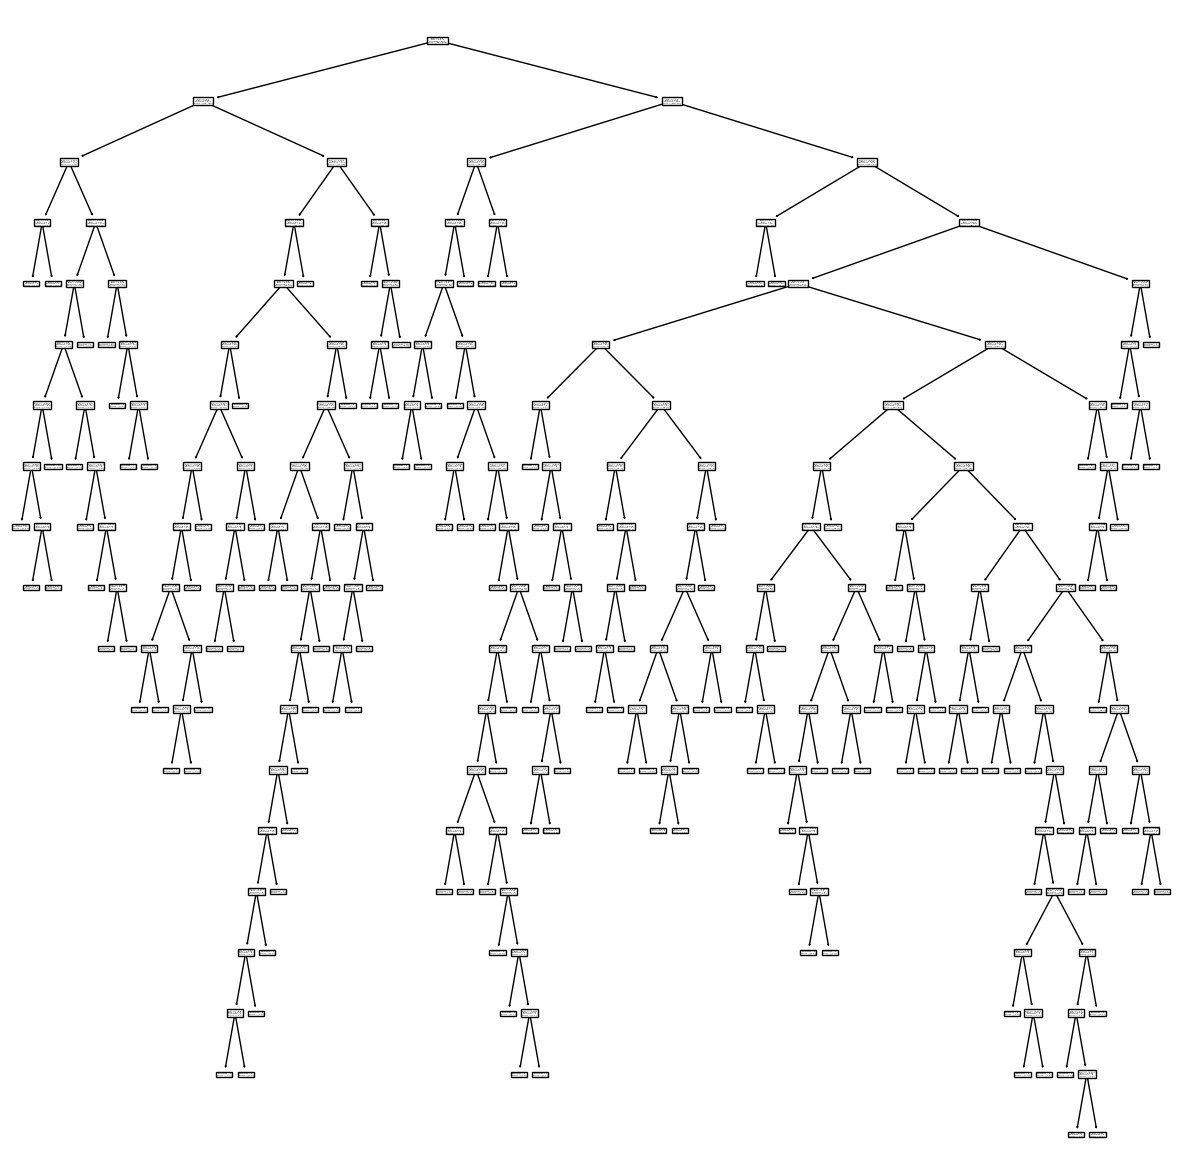

In [17]:
# the overfitting might be a resultant of letting the tree grow to its max depth.

import matplotlib.pyplot as plt
plt.figure(figsize = (15,15))
sklearn.tree.plot_tree(dtc)

In [20]:
# we can use our final pipeline to perform k-fold cros validation using grid search

from sklearn.model_selection import GridSearchCV 



hyperParametersGrid =  {'dtcModel__criterion':['gini', 'entropy', 'log_loss'],
                        'dtcModel__max_depth' : np.arange(2,11)} # model's name in the pipeline followed by two(2) '_'(underscores) and hyperparmetername


gsDtc = GridSearchCV(dtcPipeline,
                     hyperParametersGrid,
                     cv = 15
                     )

In [21]:
gsDtc.fit(xTrain, yTrain)

GridSearchCV(cv=15,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('contDataPipeLine',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('yeoJohnsonTransformation',
                                                                                          PowerTransformer()),
                                                                                         ('standardization',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'fare']),
                                                                        ('catNominalDataPipeLine',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('oneHotEncoding',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['sex',
                                                                          'embarked'])])),
                                       ('dtcModel', DecisionTreeClassifier())]),
             param_grid={'dtcModel__criterion': ['gini', 'entropy', 'log_loss'],
                         'dtcModel__max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [22]:
gsDtc.best_params_

{'dtcModel__criterion': 'entropy', 'dtcModel__max_depth': 4}

In [23]:
yTestGsPred = gsDtc.predict(xTest)

In [24]:
yTrainGsPred = gsDtc.predict(xTrain)

In [25]:
accuracy_score(yTrain, yTrainGsPred)

0.8446280991735537

In [26]:
accuracy_score(yTest, yTestGsPred)

0.8216783216783217